## Astoria  conquest

I've been living in Astoria for the past 2 years. I usually run around the roosvelt Island that's not far away from my house. One day I was exploring the area and I found out that there are a lot of good places to know in here. So, that's why I decided to run all astoria 10 miles at the time.

This project is simple but not easy: I want to run all the street of astoria, starting from my house and finishing at the gym since I like to do sauna after running.

First, we needed to know what are the boundaries of this challenge for that we went to the NYC database and collect the data from the neighborhood tabulation, NTAS LINK (https://data.cityofnewyork.us/City-Government/2020-Neighborhood-Tabulation-Areas-NTAs-/9nt8-h7nd/about_data)

second,  of all, we will use Strava to record all my runs, so every time I run this one will be uploaded to the file that way I will see how many miles I have left to run

Challenges:
The main challenge is the optimization of this project since I want to run at least 8 miles each time, but also I want to do it in the list runs as possible therefore we have a optimization of routes. 

So in real time requires the API from Strava and also I want to connect with my wo whoop data that way we have un holistic view of what happened in my runnings since I want to know what are the main factors for me to have a good run meaning a good pace and a stable pace.



## 1. Data loading and first exploration

In [3]:
from shapely import wkt
import geopandas as gpd
import matplotlib.pyplot as plt
import pandas as pd
CSV_PATH = "/Users/camilo/camilomartinez-portfolio/backend/lab/astoria_routes/2020_Neighborhood_Tabulation_Areas__NTAs__20250831.csv"
data = pd.read_csv(CSV_PATH)
# Display the column names of the DataFrame
data.dtypes
data.head(2)

,BoroCode,BoroName,CountyFIPS,NTA2020,NTAName,NTAAbbrev,NTAType,CDTA2020,CDTAName,Shape_Length,Shape_Area,the_geom
0,4,Queens,81,QN0101,Astoria (North)-Ditmars-Steinway,Astr_N,0,QN01,QN01 Astoria-Queensbridge (CD 1 Equivalent),45685.63975,58301781.05,MULTIPOLYGON (((-73.88945486837545 40.77353295...
1,4,Queens,81,QN0102,Old Astoria-Hallets Point,OldAstr,0,QN01,QN01 Astoria-Queensbridge (CD 1 Equivalent),15102.26240,11091067.00,MULTIPOLYGON (((-73.92827730832717 40.77689897...


In [4]:
%pip install geopandas shapely matplotlib pandas centerline 

Note: you may need to restart the kernel to use updated packages.


🔄 Loading and cleaning CSV data...
   • Total rows: 8
   • Checking geometry column...
   • Rows with empty/null geometry: 0
🔄 Parsing WKT geometries...
   • Warning: Failed to parse geometry: ParseException: Expected word but encountered end of stream...
   • Removing 1 rows with failed geometry parsing...
✅ Successfully parsed 7 geometries
🔄 Filtering for Astoria neighborhoods...
   • Available neighborhoods: ['Astoria (Central)', 'Astoria (East)-Woodside (North)', 'Astoria Park', 'Old Astoria-Hallets Point', 'Queensbridge-Ravenswood-Dutch Kills', "St. Michael's Cemetery", 'Sunnyside Yards (North)']
✅ Found 3 Astoria neighborhoods


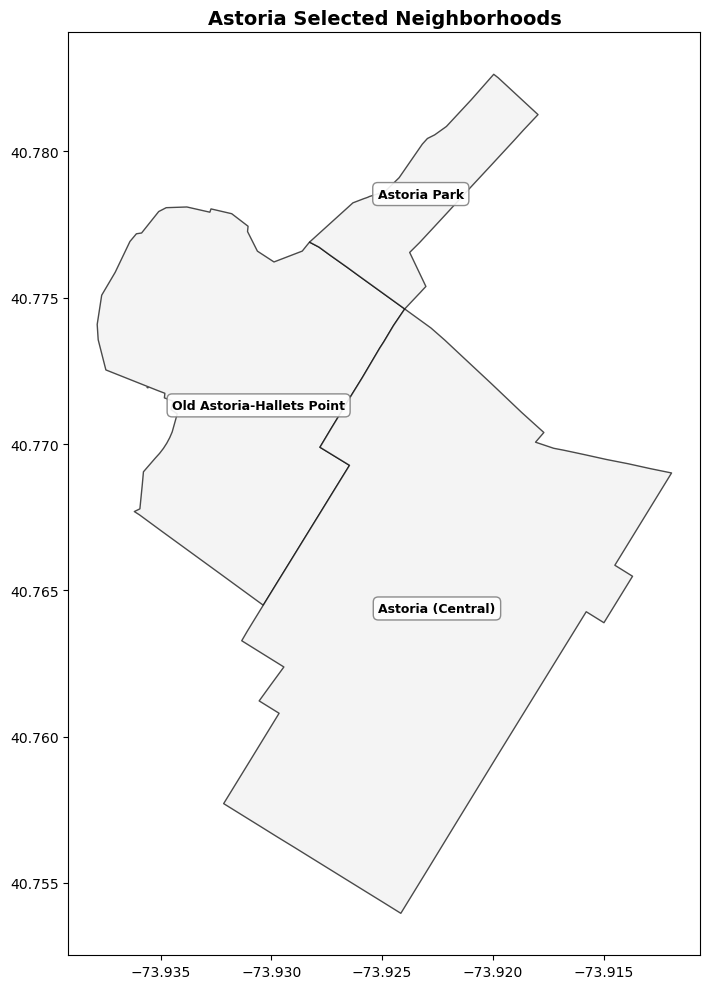

📊 Summary:
   • Neighborhoods included: ['Old Astoria-Hallets Point', 'Astoria (Central)', 'Astoria Park']
   • Total area covered: 0.000345 square degrees


/var/folders/l6/7c34hv4d1qxf6512mr1v27cc0000gn/T/ipykernel_16923/2184614003.py:98: UserWarning: Geometry is in a geographic CRS. Results from 'area' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  print(f"   • Total area covered: {gdf_astoria.geometry.area.sum():.6f} square degrees")


In [5]:
# Fixed geometry loading with error handling
from shapely import wkt
import geopandas as gpd
import matplotlib.pyplot as plt
import pandas as pd

CSV_PATH = "/Users/camilo/camilomartinez-portfolio/backend/lab/astoria_routes/2020_Neighborhood_Tabulation_Areas__NTAs__20250831.csv"

print("🔄 Loading and cleaning CSV data...")
data = pd.read_csv(CSV_PATH)

# First, let's check for any issues with the geometry column
print(f"   • Total rows: {len(data)}")
print(f"   • Checking geometry column...")

# Check for empty or null geometry values
empty_geom = data['the_geom'].isnull() | (data['the_geom'] == '') | (data['the_geom'].str.strip() == '')
print(f"   • Rows with empty/null geometry: {empty_geom.sum()}")

if empty_geom.sum() > 0:
    print("   • Removing rows with invalid geometry...")
    data = data[~empty_geom].copy()
    print(f"   • Remaining rows: {len(data)}")

# Safe WKT parsing with error handling
def safe_wkt_load(wkt_string):
    """Safely load WKT geometry with error handling"""
    try:
        if pd.isna(wkt_string) or wkt_string.strip() == '':
            return None
        return wkt.loads(wkt_string)
    except Exception as e:
        print(f"   • Warning: Failed to parse geometry: {str(e)[:100]}...")
        return None

print("🔄 Parsing WKT geometries...")
wkt_series = data['the_geom'].apply(safe_wkt_load)

# Remove any rows where geometry parsing failed
valid_geom = wkt_series.notna()
if not valid_geom.all():
    failed_count = (~valid_geom).sum()
    print(f"   • Removing {failed_count} rows with failed geometry parsing...")
    data = data[valid_geom].copy()
    wkt_series = wkt_series[valid_geom]

print(f"✅ Successfully parsed {len(wkt_series)} geometries")

# Create a GeoDataFrame
gdf = gpd.GeoDataFrame(data, geometry=wkt_series, crs="EPSG:4326")

# Filter for Astoria neighborhoods
keep_names = {
    "Astoria (Central)",
    "Old Astoria-Hallets Point", 
    "Astoria Park"
}

print(f"🔄 Filtering for Astoria neighborhoods...")
print(f"   • Available neighborhoods: {sorted(data['NTAName'].unique())}")

gdf_astoria = gdf[gdf["NTAName"].isin(keep_names)].copy()
print(f"✅ Found {len(gdf_astoria)} Astoria neighborhoods")

if len(gdf_astoria) == 0:
    print("❌ No matching neighborhoods found! Check neighborhood names.")
    print("Available names:")
    for name in sorted(data['NTAName'].unique()):
        if 'astoria' in name.lower():
            print(f"   • {name}")
else:
    # Plot the neighborhoods
    fig, ax = plt.subplots(figsize=(12, 10))
    gdf_astoria.plot(ax=ax, edgecolor='black', facecolor='#f0f0f0', alpha=0.7)

    # Add labels
    for _, row in gdf_astoria.iterrows():
        p = row.geometry.representative_point()
        ax.annotate(
            row["NTAName"],
            xy=(p.x, p.y),
            ha="center", va="center",
            fontsize=9, fontweight='bold',
            bbox=dict(
                boxstyle="round,pad=0.4",
                facecolor="white",
                alpha=0.9,
                edgecolor="gray"
            )
        )

    ax.set_title("Astoria Selected Neighborhoods", fontsize=14, fontweight='bold')
    plt.tight_layout()
    plt.show()
    
    print(f"📊 Summary:")
    print(f"   • Neighborhoods included: {list(gdf_astoria['NTAName'])}")
    print(f"   • Total area covered: {gdf_astoria.geometry.area.sum():.6f} square degrees")

In [6]:
## add image of the astoria 

From the NYC NTA dataset, Astoria isn’t a single polygon — it’s split into multiple zones. To match the “real-life” idea of Astoria from the left map, you’d want to include these zones:

⸻

✅ Zones to include for Astoria
	•	Astoria (Central)
	•	Astoria (North)–Ditmars–Steinway
	•	Old Astoria–Hallets Point
	•	Astoria Park
	•	Astoria (East)–Woodside (North)
	•	Queensbridge–Ravenswood–Dutch Kills (southern border often counted as part of Astoria)

⸻

⚠️ Zones to exclude
	•	Sunnyside Yards (North) → belongs to Sunnyside/Woodside, not Astoria.
	•	St. Michael’s Cemetery → technically a separate land-use zone, not part of Astoria proper.

## 2. Planning for the optimized routes four this challenge

We want the best routes possible to compleate the challenges with the least amount of races. 

This mathematical problem is called Multi-constrained Geographic Arc Routing Problem (MC-GARP).

Objective: minimize the through number of runs needed to Traverse every single street in Astoria.

### constraints:
* **Geographic Boundary Contraints**: All routes segments must remain within defined Astoria polygons.
* **Distance Constraint**: each must be between 6 to 12 miles
* **Coverage requirements**: each Street should be run at least once.
* **Connectivity constraints**:  route can only use actual street intersections as waypoint

Why This Is Computationally Challenging:

Exponential solution space: With ~1000 intersections in Astoria, possible routes grow exponentially
Geometric validation required: Each route segment needs polygon containment checking
Multi-objective optimization: Balancing coverage, distance, and boundary compliance
Irregular geography: Astoria's shape doesn't partition evenly into 6-12 mile zones


## Solution:
## Phase 1: Graph Construction & Modeling 🗺️

First, we'll transform the real-world map of Astoria into a digital graph. Using OpenStreetMap data, we will model all street intersections as nodes and the streets connecting them as weighted edges, ensuring every segment is contained within Astoria's geographic boundary. This creates the digital playground where we can solve the problem.

## Phase 2: Initial Solution - The Greedy Heuristic ➡️

Next, we'll generate a complete "first draft" of the running plan. A fast greedy algorithm will quickly create a set of runs that satisfies all constraints (6-12 miles, home-to-gym, full coverage). This provides a valid, but suboptimal, solution that serves as the starting point for true optimization.

## Phase 3: Core Optimizer - Adaptive Large Neighborhood Search (ALNS)

This is the core of the project. The ALNS metaheuristic will intelligently refine the initial solution to achieve the minimum number of runs. It works in a powerful "destroy and repair" cycle:

Destroy: It strategically breaks apart the current plan, removing a few routes or street segments.

Repair: It then rebuilds the solution using smart heuristics to re-insert the removed segments in more efficient ways.

Decide: It keeps the improved plans and uses advanced logic to avoid getting stuck, ensuring it finds a globally optimal solution.

This iterative process systematically consolidates runs, reduces redundancy, and finds the most efficient way to cover every street in Astoria.

In [9]:
%pip install osmnx networkx folium shapely geopandas pandas osmnx

Note: you may need to restart the kernel to use updated packages.


## Phase 1: Graph Construction & Modeling

The osmx database ( https://www.openstreetmap.org/) has all the geolocations we needed inside our interest zone, but they have multiple stret types, as we can see in the follwoing table, "footway" is the one that was interesting. But after further examination we decidded to ommit it since each street due to its double direction would be counted double, which make it more difficult to get a proper model running.  our street types are:
* Residentilal
* Tertiary
* Secondary
* Unclassified
* Living_street



In [ ]:
import osmnx as ox
import pandas as pd
from shapely.ops import unary_union
        
astoria_boundary = unary_union(gdf_astoria.geometry.values)
    
# Create the graph
G = ox.graph_from_polygon(
    astoria_boundary, 
    network_type='walk',
    retain_all=True,
    truncate_by_edge=True
)
print(f"✅ Graph created with {len(G.nodes())} nodes and {len(G.edges())} edges")

# Now create the street types table
edges_gdf = ox.graph_to_gdfs(G, nodes=False)
highway_counts = edges_gdf['highway'].value_counts()

# Create a simple table
street_table = pd.DataFrame({
    'Street Type': highway_counts.index,
    'Count': highway_counts.values,
    'Percentage': (highway_counts.values / len(edges_gdf) * 100).round(1)
})

print("🛣️ Astoria Street Types Summary")
print(street_table.to_string(index=False))

⚠️ Graph G not found. Creating it now...
Creating astoria_boundary...
✅ Graph created with 2164 nodes and 7160 edges
🛣️ Astoria Street Types Summary
             Street Type  Count  Percentage
                 footway   4790        66.9
             residential    962        13.4
                 service    604         8.4
                tertiary    360         5.0
               secondary    278         3.9
                 primary     84         1.2
        [footway, steps]     20         0.3
              pedestrian     20         0.3
          secondary_link     14         0.2
  [service, residential]      4         0.1
[secondary, residential]      3         0.0
[residential, secondary]      3         0.0
  [footway, residential]      2         0.0
 [residential, tertiary]      2         0.0
   [secondary, tertiary]      2         0.0
           tertiary_link      2         0.0
      [footway, service]      2         0.0
   [footway, pedestrian]      2         0.0
               

In [30]:
import osmnx as ox
import networkx as nx
import folium
from shapely.geometry import Point, LineString
from shapely.ops import unary_union
import geopandas as gpd
from shapely import wkt
import pandas as pd

home_coords = (40.75515949421703, -73.92659518768713) #this is where each run would start
gym_coords = (40.76179269164385, -73.92492219946743) #this is where each run would end

# Add edge lengths in meters, then convert to miles for your distance constraints
G = ox.add_edge_speeds(G)  # Adds travel speeds
G = ox.add_edge_travel_times(G)  # Adds travel times  

# Calculate length in miles for each edge (street segment)
for u, v, key, data in G.edges(keys=True, data=True):
    if 'length' in data:
        # Convert meters to miles (1 meter = 0.000621371 miles)
        data['length_miles'] = data['length'] * 0.000621371
    else:
        # Fallback: calculate from node coordinates if length missing
        node1 = G.nodes[u]
        node2 = G.nodes[v]
        point1 = Point(node1['x'], node1['y'])
        point2 = Point(node2['x'], node2['y'])
        # Use approximate distance calculation
        distance_meters = point1.distance(point2) * 111000  # Rough lat/lon to meters
        data['length_miles'] = distance_meters * 0.000621371

print(f"✅ Added distance weights to all street segments")

# Step 4: Add home and gym as special nodes
# We need to connect your start/end points to the street network
print("🔄 Step 4: Adding home and gym locations to network...")


✅ Added distance weights to all street segments
🔄 Step 4: Adding home and gym locations to network...


🎨 Creating detailed visualization of G_final_streets...
📊 G_final_streets contains 626 edges
   • residential: 346 segments
   • tertiary: 164 segments
   • secondary: 112 segments
   • unclassified: 0 segments
   • living_street: 4 segments
📊 G_final_streets contains 626 edges
   • residential: 346 segments
   • tertiary: 164 segments
   • secondary: 112 segments
   • unclassified: 0 segments
   • living_street: 4 segments


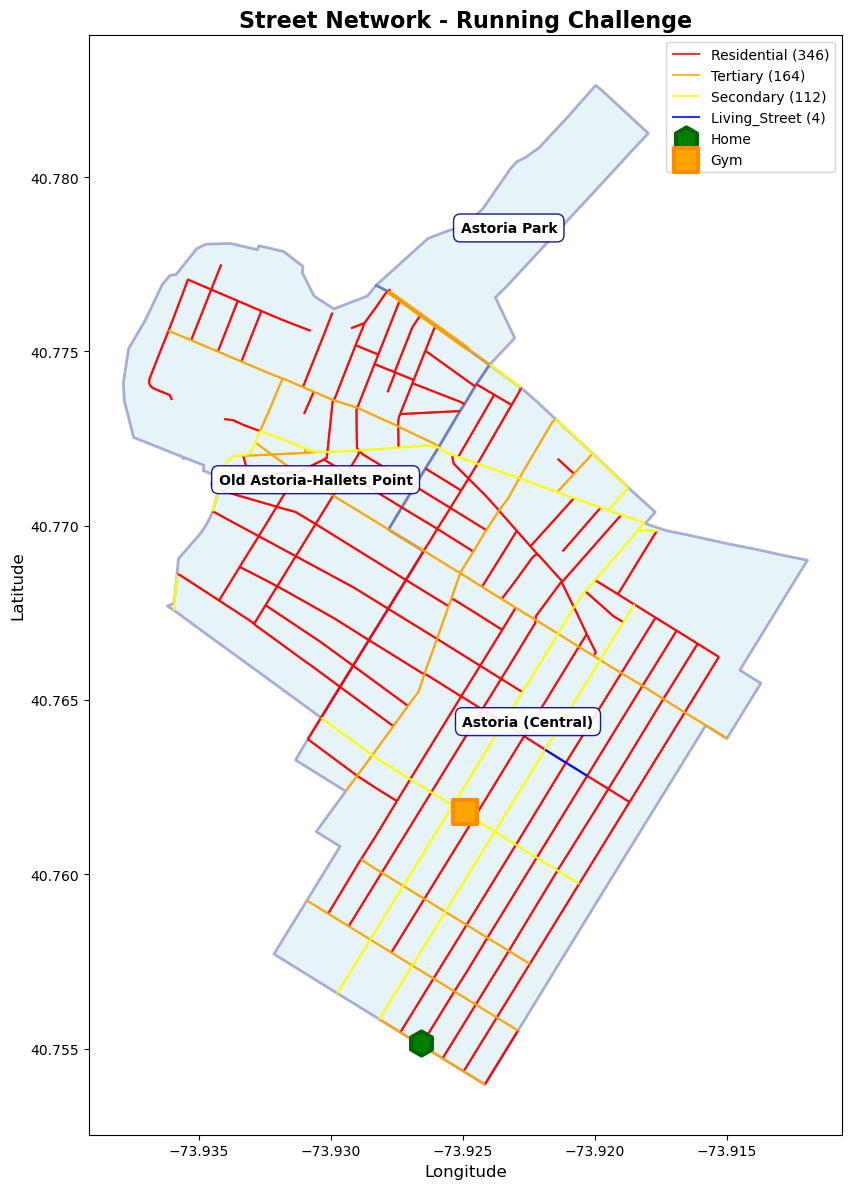


📊 G_final_streets Network Analysis:
   • residential    :  346 segments,   33.4 miles
   • tertiary       :  164 segments,    9.0 miles
   • secondary      :  112 segments,    8.3 miles
   • living_street  :    4 segments,    0.2 miles

   • TOTAL NETWORK:  626 segments,   50.9 miles
   • Reduction from original: 91.3% fewer segments


In [31]:
import geopandas as gpd
import networkx as nx
import osmnx as ox
import matplotlib.pyplot as plt

# --- ENHANCED Visualization for G_final_streets ---

print("🎨 Creating detailed visualization of G_final_streets...")

# Create visualization with proper breakdown by street type
fig, ax = plt.subplots(figsize=(15, 12))


# Plot neighborhood boundaries first
gdf_astoria.plot(ax=ax, facecolor='lightblue', edgecolor='navy', alpha=0.3, linewidth=2)

astoria_boundary = unary_union(gdf_astoria.geometry.values)

street_types_to_keep = [
    'residential',
    'tertiary',
    'secondary',
    'unclassified',
    'living_street'
]

G_final_streets = ox.graph_from_polygon(
    astoria_boundary,
    network_type='walk',
    custom_filter=f'["highway"~"{"|".join(street_types_to_keep)}"]'
)


# Convert G_final_streets to GeoDataFrame
nodes_final, edges_final = ox.graph_to_gdfs(G_final_streets)

print(f"📊 G_final_streets contains {len(edges_final)} edges")

# Define colors for each street type
running_types_colors = {
    'residential': 'red',
    'tertiary': 'orange', 
    'secondary': 'yellow',
    'unclassified': 'green',
    'living_street': 'blue'
}

# Plot streets by type with different colors
for highway_type, color in running_types_colors.items():
    # Filter edges for this highway type
    type_edges = edges_final[edges_final['highway'].astype(str).str.contains(highway_type, na=False)]
    
    if not type_edges.empty:
        type_edges.plot(ax=ax, color=color, linewidth=1.5, alpha=0.8, label=f'{highway_type.title()} ({len(type_edges)})')
        print(f"   • {highway_type}: {len(type_edges)} segments")
    else:
        print(f"   • {highway_type}: 0 segments")

# Add home and gym markers (make sure coordinates are defined)
if 'home_coords' in globals():
    ax.scatter(home_coords[1], home_coords[0], c='green', s=300, marker='h', 
               label='Home', zorder=10, edgecolors='darkgreen', linewidth=3)
if 'gym_coords' in globals():
    ax.scatter(gym_coords[1], gym_coords[0], c='orange', s=300, marker='s', 
               label='Gym', zorder=10, edgecolors='darkorange', linewidth=3)

# Add neighborhood labels
for _, row in gdf_astoria.iterrows():
    p = row.geometry.representative_point()
    ax.annotate(
        row["NTAName"],
        xy=(p.x, p.y),
        ha="center", va="center",
        fontsize=10, fontweight='bold',
        bbox=dict(boxstyle="round,pad=0.5", facecolor="white", 
                 alpha=0.9, edgecolor="navy")
    )

# Styling
ax.set_title("Street Network - Running Challenge", fontsize=16, fontweight='bold')
ax.legend(loc='upper right', fontsize=10)
ax.set_xlabel("Longitude", fontsize=12)
ax.set_ylabel("Latitude", fontsize=12)
ax.tick_params(axis='both', which='major', labelsize=10)

plt.tight_layout()
plt.show()

# --- Calculate and Display Statistics ---
print(f"\n📊 G_final_streets Network Analysis:")
print("=" * 50)

# Calculate total distance by type
total_distance_by_type = {}
total_distance_all = 0

for highway_type in running_types_colors.keys():
    type_edges = edges_final[edges_final['highway'].astype(str).str.contains(highway_type, na=False)]
    if not type_edges.empty and 'length' in type_edges.columns:
        distance_miles = (type_edges['length'] * 0.000621371).sum()
        total_distance_by_type[highway_type] = distance_miles
        total_distance_all += distance_miles
        print(f"   • {highway_type:<15}: {len(type_edges):>4} segments, {distance_miles:>6.1f} miles")

print(f"\n   • TOTAL NETWORK: {len(edges_final):>4} segments, {total_distance_all:>6.1f} miles")

# Compare with original network if available
if 'G' in globals():
    original_edges = len(G.edges())
    reduction_percentage = ((original_edges - len(edges_final)) / original_edges) * 100
    print(f"   • Reduction from original: {reduction_percentage:.1f}% fewer segments")

print("=" * 50)

SyntaxError: invalid syntax. Perhaps you forgot a comma? (3750623026.py, line 83)

## Phase 2: Initial Solution - The Greedy Heuristic ➡️


In [24]:
import pandas as pd
import networkx as nx
import time
import numpy as np

# --- Phase 6: FINAL OPTIMIZED & SMARTER Greedy Heuristic ---

print("🏃‍♂️ Starting the FINAL OPTIMIZED greedy algorithm (fast with turn penalty)...")
start_time = time.time()

# --- Configuration ---
# A higher weight means the algorithm will try harder to go straight.
turn_penalty_weight = 150 

# --- Helper Functions ---
def get_path_distance(graph, path):
    """Efficiently calculate the total distance of a path in meters."""
    return sum(graph.edges[u, v, 0]['length'] for u, v in zip(path[:-1], path[1:]))

def calculate_bearing(lat1, lon1, lat2, lon2):
    """Calculates the bearing between two points."""
    lon1, lat1, lon2, lat2 = map(np.radians, [lon1, lat1, lon2, lat2])
    dLon = lon2 - lon1
    x = np.sin(dLon) * np.cos(lat2)
    y = np.cos(lat1) * np.sin(lat2) - np.sin(lat1) * np.cos(lat2) * np.cos(dLon)
    initial_bearing = np.arctan2(x, y)
    initial_bearing = np.degrees(initial_bearing)
    return (initial_bearing + 360) % 360

# --- Main Algorithm ---
generated_runs = []
run_count = 0
uncovered_edges = {(u, v) for u, v, k, data in G.edges(keys=True, data=True)}

while uncovered_edges:
    run_count += 1
    print(f"\n--- Building Run #{run_count} ---")
    
    current_path = [start_node]
    last_bearing = None

    while get_path_distance(G, current_path) < (MIN_DISTANCE_MILES * 1609.34):
        if not uncovered_edges:
            print("   - All streets covered.")
            break
            
        last_node = current_path[-1]
        
        # Determine current bearing
        if len(current_path) > 1:
            node1 = G.nodes[current_path[-2]]
            node2 = G.nodes[last_node]
            last_bearing = calculate_bearing(node1['y'], node1['x'], node2['y'], node2['x'])

        # --- COMBINED OPTIMIZATION ---
        # 1. Calculate distances AND paths to all nodes at once
        distances = nx.single_source_dijkstra_path_length(G, source=last_node, weight='length')
        paths = nx.single_source_dijkstra_path(G, source=last_node, weight='length')
        
        best_edge = None
        min_cost = float('inf')

        for u, v in uncovered_edges:
            if u in distances:
                distance_cost = distances[u]
                
                turn_penalty = 0
                if last_bearing is not None:
                    path_to_u = paths[u]
                    if len(path_to_u) > 1:
                        node_current = G.nodes[last_node]
                        node_next = G.nodes[path_to_u[1]]
                        path_bearing = calculate_bearing(node_current['y'], node_current['x'], node_next['y'], node_next['x'])
                        
                        angle_diff = 180 - abs(abs(last_bearing - path_bearing) - 180)
                        turn_penalty = angle_diff

                # Combined cost with a heavier penalty for turns on distant streets
                cost = distance_cost + (turn_penalty * (distance_cost / 1000) * turn_penalty_weight)
                
                if cost < min_cost:
                    min_cost = cost
                    best_edge = (u, v)
        # --- END OPTIMIZATION ---

        if best_edge is None:
            print("   - Warning: Could not find a path to any remaining uncovered edges.")
            break
            
        path_to_next_edge = paths[best_edge[0]]
        current_path.extend(path_to_next_edge[1:])
        current_path.append(best_edge[1])
        
        # Update uncovered set, removing the edge in both directions
        uncovered_edges.discard(best_edge)
        uncovered_edges.discard((best_edge[1], best_edge[0]))

        current_distance_miles = get_path_distance(G, current_path) / 1609.34
        print(f"   - Added edge {best_edge}. Current distance: {current_distance_miles:.2f} miles.")

    # Complete the run
    last_node = current_path[-1]
    path_to_gym = nx.shortest_path(G, source=last_node, target=end_node, weight='length')
    current_path.extend(path_to_gym[1:])
    
    final_distance_miles = get_path_distance(G, current_path) / 1609.34
    
    generated_runs.append({
        'run_id': run_count,
        'path': current_path,
        'distance_miles': final_distance_miles
    })
    print(f"✅ Finished Run #{run_count}. Final distance: {final_distance_miles:.2f} miles.")

# --- Summary ---
end_time = time.time()
print("\n" + "="*50)
print("Final Greedy Heuristic Plan Summary")
print("="*50)
print(f"Algorithm runtime: {end_time - start_time:.2f} seconds.")

if generated_runs:
    runs_df = pd.DataFrame(generated_runs)
    total_miles_run = runs_df['distance_miles'].sum()
    
    print(f"Generated a total of {len(runs_df)} runs.")
    print(f"Total distance to run across all routes: {total_miles_run:.2f} miles.")
    print(f"Average distance per run: {runs_df['distance_miles'].mean():.2f} miles.")
    
    print("\n--- Run Details ---")
    print(runs_df[['run_id', 'distance_miles']].round(2))
else:
    print("No runs were generated.")

print("="*50)

🏃‍♂️ Starting the FINAL OPTIMIZED greedy algorithm (fast with turn penalty)...

--- Building Run #1 ---


NameError: name 'start_node' is not defined

In [ ]:
# --- Phase 7: Visualize a Single Route ---

# Choose which run you want to see (e.g., run_id 1)
run_to_plot = generated_runs[1]['path'] 

# Create a plot of the street network with the selected route highlighted
fig, ax = ox.plot_graph_route(
    G, 
    run_to_plot, 
    route_color='lime', 
    route_linewidth=4, 
    node_size=0,
    bgcolor='k',
    edge_color='gray',
    edge_linewidth=0.5,
    figsize=(15, 15)
)

# Add Home and Gym markers
ax.scatter(home_coords[1], home_coords[0], c='green', s=250, marker='h', 
           label='Home', zorder=10, edgecolors='white')
ax.scatter(gym_coords[1], gym_coords[0], c='orange', s=250, marker='s', 
           label='Gym', zorder=10, edgecolors='white')

ax.set_title("Path for Run #1", fontsize=20, color='white')
plt.legend()
plt.show()

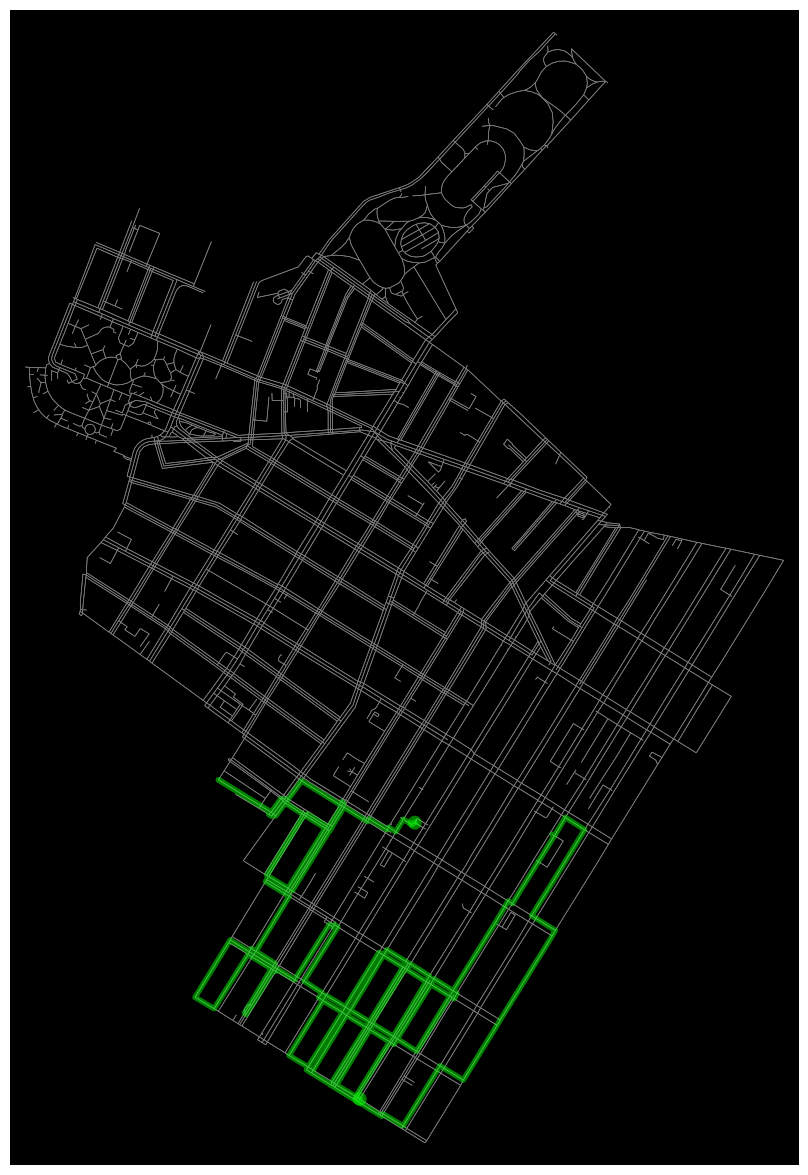

/var/folders/l6/7c34hv4d1qxf6512mr1v27cc0000gn/T/ipykernel_12871/363603192.py:26: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()


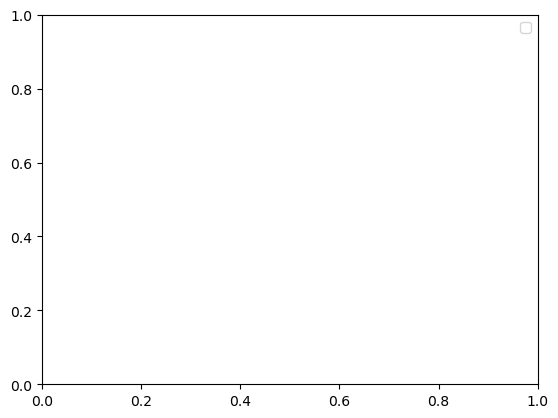

In [72]:
# --- Phase 7: Visualize a Single Route ---

# Choose which run you want to see (e.g., run_id 1)
run_to_plot = generated_runs[0]['path'] 

# Create a plot of the street network with the selected route highlighted
fig, ax = ox.plot_graph_route(
    G, 
    run_to_plot, 
    route_color='lime', 
    route_linewidth=4, 
    node_size=0,
    bgcolor='k',
    edge_color='gray',
    edge_linewidth=0.5,
    figsize=(15, 15)
)

# Add Home and Gym markers
ax.scatter(home_coords[1], home_coords[0], c='green', s=250, marker='h', 
           label='Home', zorder=10, edgecolors='white')
ax.scatter(gym_coords[1], gym_coords[0], c='orange', s=250, marker='s', 
           label='Gym', zorder=10, edgecolors='white')

ax.set_title("Path for Run #1", fontsize=20, color='white')
plt.legend()
plt.show()

Filtering the graph to include ONLY footways...
✅ New footway-only graph created.
   - Original graph had 7160 segments.
   - Footway-only graph has 4800 segments.


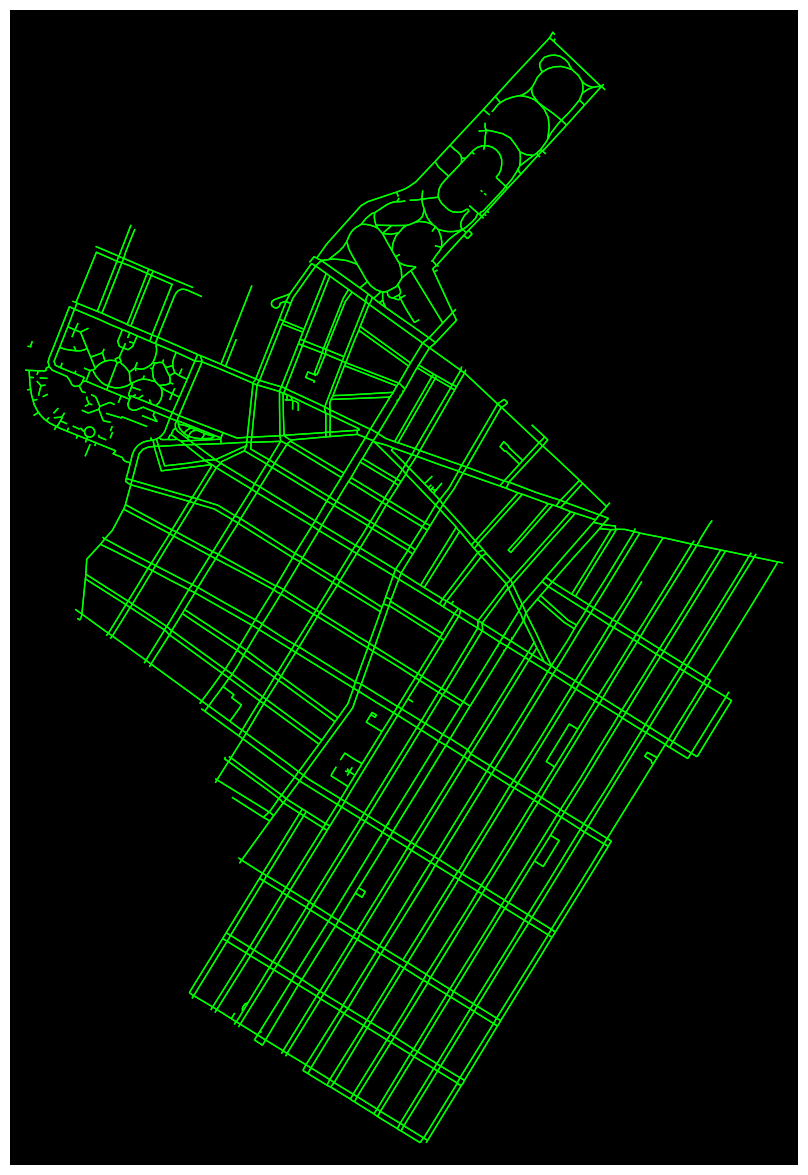

In [31]:
import networkx as nx
import matplotlib.pyplot as plt

# --- Create a Filtered Graph with ONLY Footways ---

print("Filtering the graph to include ONLY footways...")

# Define the ONLY street type we want to KEEP.
street_types_to_keep = ['footway']

# Get the original edges as a GeoDataFrame
edges_gdf = ox.graph_to_gdfs(G, nodes=False)

# Filter the GeoDataFrame to keep only the desired street types
filtered_edges_gdf = edges_gdf[edges_gdf['highway'].isin(street_types_to_keep)]

# --- FIX ---
# Reset the index to turn 'u' and 'v' from an index into regular columns
filtered_edges_gdf = filtered_edges_gdf.reset_index()
# --- END FIX ---

# Create a new graph from the filtered edges
node_ids = set(filtered_edges_gdf['u'].tolist() + filtered_edges_gdf['v'].tolist())
G_footway_only = G.subgraph(node_ids).copy()

# Remove any edges that weren't in our filtered list
edges_to_remove = []
for u, v, key in G_footway_only.edges(keys=True):
    # This check is needed because subgraph includes all edges between the selected nodes
    edge_df = filtered_edges_gdf[(filtered_edges_gdf['u'] == u) & (filtered_edges_gdf['v'] == v)]
    if edge_df.empty:
        edges_to_remove.append((u, v, key))
G_footway_only.remove_edges_from(edges_to_remove)

# Remove nodes that are now isolated
G_footway_only.remove_nodes_from(list(nx.isolates(G_footway_only)))

print("✅ New footway-only graph created.")
print(f"   - Original graph had {len(G.edges())} segments.")
print(f"   - Footway-only graph has {len(G_footway_only.edges())} segments.")

# --- Visualize the Footway Network ---
# We will now use G_footway_only for all future steps
fig, ax = ox.plot_graph(
    G_footway_only, 
    node_size=0,
    bgcolor='k',
    edge_color='lime',
    edge_linewidth=1,
    figsize=(15, 15)
)
ax.set_title("Astoria Network (Footways Only)", color='white')
plt.show()

In [80]:
%pip install centerline

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 14.7/14.7 MB 8.5 MB/s eta 0:00:00a 0:00:01m
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4/4 [centerline]4 [Fiona]
Note: you may need to restart the kernel to use updated packages.


In [35]:
import geopandas as gpd
from centerline.geometry import Centerline
from shapely.geometry import Polygon, MultiPolygon

# --- Create a New, Cleaner Dataset by Unifying Parallel Lines ---

print("✨ Unifying parallel footways into single centerlines...")

# 1. Convert our footway-only graph to a GeoDataFrame
footway_edges_gdf = ox.graph_to_gdfs(G_footway_only, nodes=False)

# 2. Re-project to a local CRS for accurate measurements
print("   - Re-projecting to a local coordinate system...")
projected_gdf = footway_edges_gdf.to_crs("EPSG:2263") # EPSG:2263 for NYC uses feet

# --- NEW, STRICTER FIX: Pre-filter to remove tiny, problematic line segments ---
min_length_feet = 1.0  # Remove any path shorter than 1 foot
initial_count = len(projected_gdf)
projected_gdf = projected_gdf[projected_gdf.length > min_length_feet]
print(f"   - Removed {initial_count - len(projected_gdf)} short/invalid segments.")
# --- END FIX ---

# 3. Buffer and Merge the CLEANED Geometries
buffer_distance_feet = 60
projected_gdf['geometry'] = projected_gdf.buffer(buffer_distance_feet)
merged_polygons = projected_gdf.union_all()
print("   - Buffering and merging complete.")

# 4. Robustly extract only Polygon objects
polygon_list = []
if merged_polygons.geom_type == 'Polygon':
    polygon_list = [merged_polygons]
elif merged_polygons.geom_type == 'MultiPolygon':
    polygon_list = list(merged_polygons.geoms)
elif merged_polygons.geom_type == 'GeometryCollection':
    print("   - Complex GeometryCollection found. Extracting only polygons...")
    for geom in merged_polygons.geoms:
        if geom.geom_type == 'Polygon':
            polygon_list.append(geom)
            
# 5. Calculate the Centerline
if not polygon_list:
    print("   - Error: No valid polygons found after merging. Cannot create centerlines.")
else:
    polygons_gdf = gpd.GeoDataFrame({'geometry': polygon_list}, crs="EPSG:2263")

    centerlines = Centerline(polygons_gdf, border_distance=buffer_distance_feet / 2)
    centerlines_gdf = centerlines.create_centerline()
    
    # Project the final result BACK to lat/lon for plotting
    centerlines_latlon_gdf = centerlines_gdf.to_crs(footway_edges_gdf.crs)

    print("   - Centerline calculation complete.")
    print(f"✅ New unified dataset created with {len(centerlines_latlon_gdf)} segments.")

    # --- Visualize the New, Clean Dataset ---
    print("🎨 Visualizing the unified footway network...")
    fig, ax = plt.subplots(figsize=(15, 15))
    centerlines_latlon_gdf.plot(ax=ax, color='lime', linewidth=1)
    ax.set_facecolor('k')
    ax.set_title("Unified Footway Network (Parallel Lines Merged)", color='white')
    plt.show()

✨ Unifying parallel footways into single centerlines...
   - Re-projecting to a local coordinate system...
   - Removed 0 short/invalid segments.
   - Buffering and merging complete.


InvalidInputTypeError: Input geometry must be of type shapely.geometry.Polygon or shapely.geometry.MultiPolygon!

🩺 Performing a health check on the merged polygon data...
   - Found 2 total geometric shapes to process.
   - Geometry Types Found: {'Polygon': 2}
   - ✅ All geometries are valid.

🎨 Visualizing the merged polygons before creating centerlines...


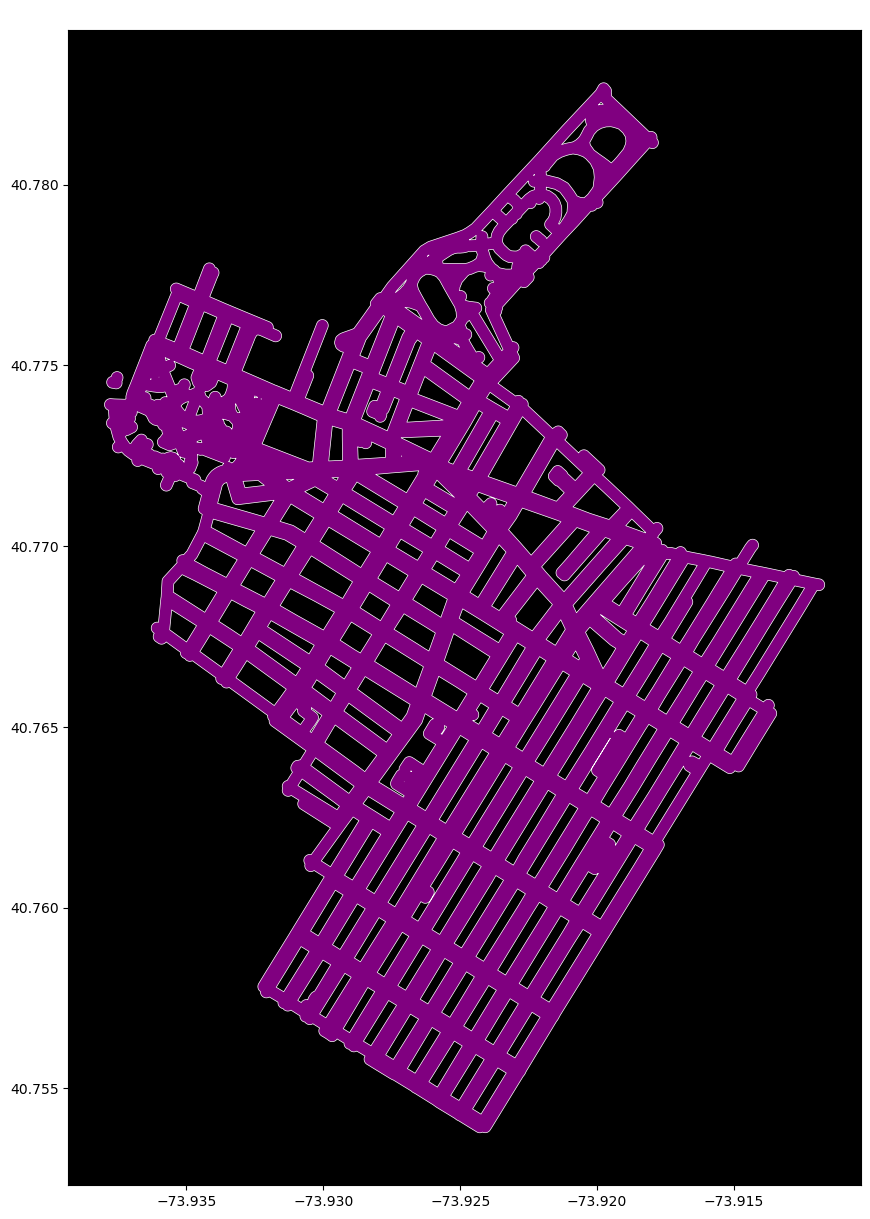

In [36]:
import geopandas as gpd
import matplotlib.pyplot as plt
from collections import Counter

# --- DEBUGGING STEP: Perform a "Health Check" on the Polygon Data ---

print("🩺 Performing a health check on the merged polygon data...")

if not polygon_list:
    print("   - Result: The polygon list is empty. No data to process.")
else:
    # 1. Print a report on the geometry types and validity
    print(f"   - Found {len(polygon_list)} total geometric shapes to process.")
    
    # Check the types of geometries in the list
    geom_types = [geom.geom_type for geom in polygon_list]
    type_counts = Counter(geom_types)
    print(f"   - Geometry Types Found: {dict(type_counts)}")

    # Check for invalid geometries (like self-intersecting "bowtie" polygons)
    invalid_geoms = [geom for geom in polygon_list if not geom.is_valid]
    if invalid_geoms:
        print(f"   - ⚠️ WARNING: Found {len(invalid_geoms)} invalid geometries!")
    else:
        print("   - ✅ All geometries are valid.")

    # 2. Visualize the polygons that we are about to process
    print("\n🎨 Visualizing the merged polygons before creating centerlines...")
    
    # Create a GeoDataFrame for inspection using the projected CRS
    polygons_gdf_for_inspection = gpd.GeoDataFrame({'geometry': polygon_list}, crs="EPSG:2263")
    
    # Project back to Lat/Lon for plotting
    polygons_gdf_for_inspection_latlon = polygons_gdf_for_inspection.to_crs("EPSG:4326")

    fig, ax = plt.subplots(figsize=(15, 15))
    polygons_gdf_for_inspection_latlon.plot(ax=ax, facecolor='purple', edgecolor='white', linewidth=0.5)
    
    ax.set_facecolor('k')
    ax.set_title("Health Check: Visualization of the Merged Polygons", color='white')
    plt.show()

✨ Implementing a more robust method to simplify the network...
   - Removed 3369 parallel duplicate segments.
✅ New simplified dataset created with 1431 segments.
🎨 Visualizing the final simplified network...


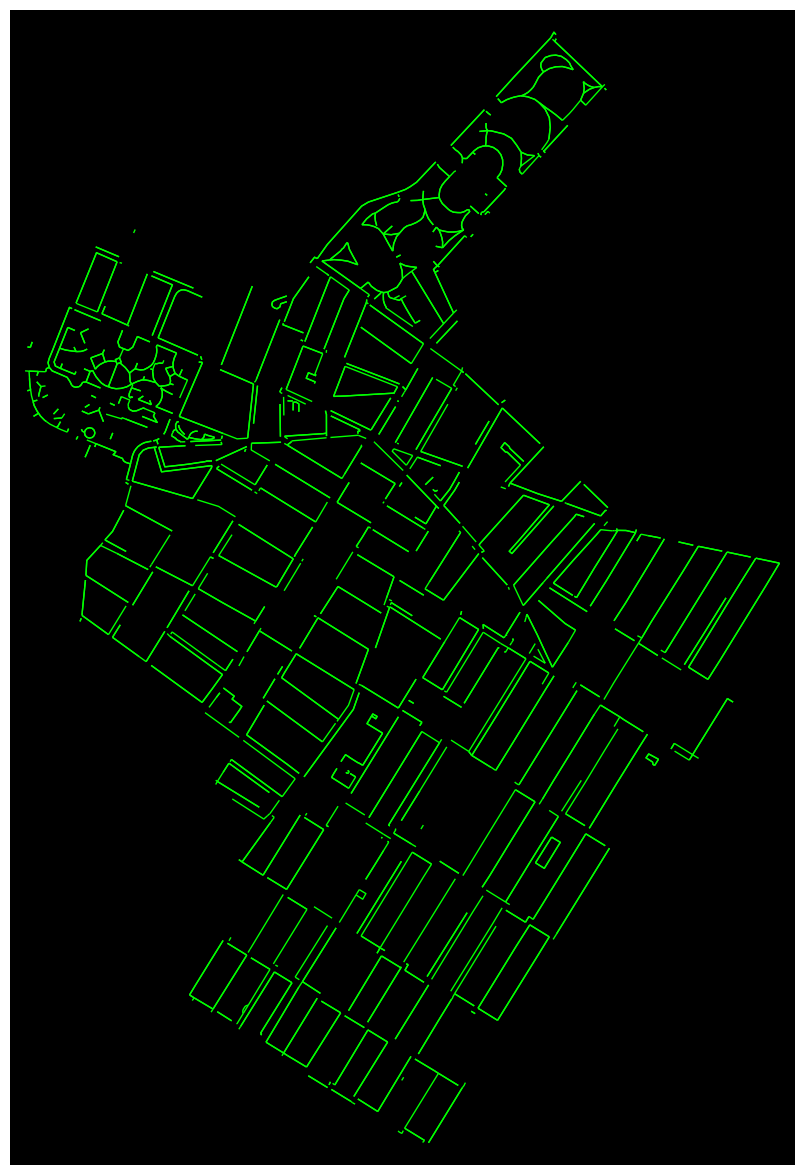

In [45]:
import geopandas as gpd
import networkx as nx
import osmnx as ox

# --- Final Data Cleaning: A More Robust Method to Remove Parallel Footways ---

print("✨ Implementing a more robust method to simplify the network...")

# 1. Convert the footway graph to a GeoDataFrame
# We use ox.bearing.add_edge_bearings to get the angle of each segment
G_footway_with_bearings = ox.bearing.add_edge_bearings(G_footway_only)
footway_edges_gdf = ox.graph_to_gdfs(G_footway_with_bearings, nodes=False).reset_index()

# --- New Logic to find and remove parallel duplicates ---
indices_to_drop = set()
processed_indices = set()
distance_threshold = 25  # Max distance in meters to be considered a parallel pair

# Project to a local CRS for accurate distance measurement
footway_edges_projected = footway_edges_gdf.to_crs("EPSG:2263") # Uses feet

for index1, row1 in footway_edges_projected.iterrows():
    if index1 in processed_indices:
        continue

    line1 = row1.geometry
    bearing1 = row1.bearing
    
    # Find potential duplicates that are geographically close
    possible_duplicates_indices = footway_edges_projected.sindex.query(line1.buffer(distance_threshold * 3.28084), predicate="intersects")
    
    parallel_cluster = {index1}
    
    for index2 in possible_duplicates_indices:
        if index2 in processed_indices or index1 == index2:
            continue

        row2 = footway_edges_projected.loc[index2]
        bearing2 = row2.bearing

        # Check if bearings are similar (either same direction or opposite)
        angle_diff = abs(bearing1 - bearing2)
        if min(angle_diff, 360 - angle_diff) < 10: # Allow 10-degree deviation for same direction
            parallel_cluster.add(index2)

    # From the cluster of parallel lines, keep only the longest one
    if len(parallel_cluster) > 1:
        cluster_gdf = footway_edges_projected.loc[list(parallel_cluster)]
        longest_edge_index = cluster_gdf['length'].idxmax()
        
        # Mark all other edges in the cluster for removal
        for idx in parallel_cluster:
            if idx != longest_edge_index:
                indices_to_drop.add(idx)
    
    # Mark all in the cluster as processed so we don't re-check them
    processed_indices.update(parallel_cluster)

# Drop the identified duplicates from the original (non-projected) DataFrame
cleaned_footways_gdf = footway_edges_gdf.drop(list(indices_to_drop))

print(f"   - Removed {len(indices_to_drop)} parallel duplicate segments.")
print(f"✅ New simplified dataset created with {len(cleaned_footways_gdf)} segments.")

# --- Create the Final Graph for Routing ---
# We build a new graph using ONLY the cleaned edges
node_ids = set(cleaned_footways_gdf['u'].tolist() + cleaned_footways_gdf['v'].tolist())
G_final = G_footway_only.subgraph(node_ids).copy() # Start from the footway graph again

edges_to_remove = []
final_edges_set = set(zip(cleaned_footways_gdf['u'], cleaned_footways_gdf['v']))
for u, v, key in G_final.edges(keys=True):
    if (u, v) not in final_edges_set:
        edges_to_remove.append((u, v, key))
G_final.remove_edges_from(edges_to_remove)
G_final.remove_nodes_from(list(nx.isolates(G_final)))

# --- Visualize the Final, Clean Network ---
print("🎨 Visualizing the final simplified network...")
fig, ax = ox.plot_graph(
    G_final, 
    node_size=0,
    bgcolor='k',
    edge_color='lime',
    edge_linewidth=1,
    figsize=(15, 15)
)
ax.set_title("Final Simplified Footway Network", color='white')
plt.show()

# We will now use 'G_final' for the routing algorithm.

✨ Building the final network from core streets (not sidewalks)...
✅ Final, clean street graph created with 626 segments.
🎨 Visualizing the final simplified network...


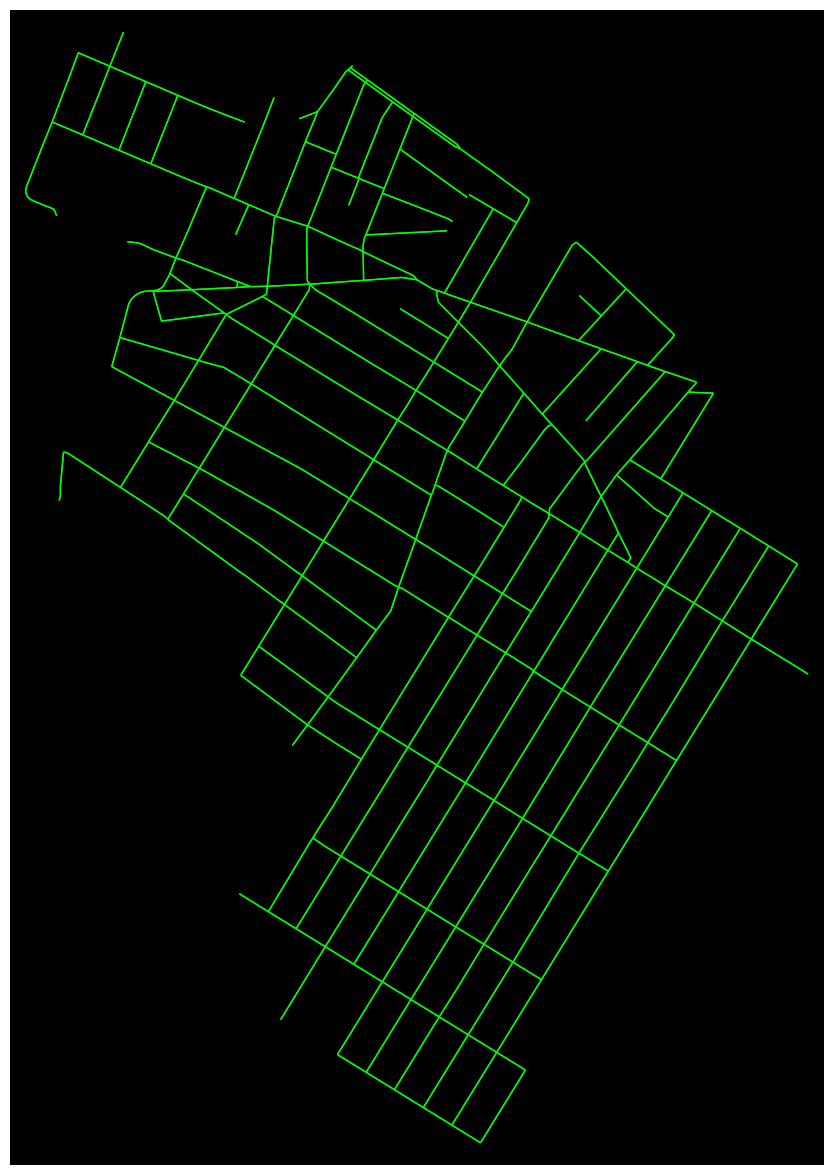

In [58]:
import geopandas as gpd
import networkx as nx
import osmnx as ox

# --- FINAL Data Prep: Build Graph from the Clean Street Network ---

print("✨ Building the final network from core streets (not sidewalks)...")

# Ensure astoria_polygon is defined
if 'astoria_polygon' not in globals():
    astoria_polygon = gdf_astoria.unary_union
    print("✅ astoria_polygon created from gdf_astoria.")

# Define the types of streets we want to KEEP.
# This list represents the actual road network.
street_types_to_keep = [
    'residential', 
    'tertiary', 
    'secondary', 
    'unclassified', 
    'living_street'
]

# Create a new graph using OSMnx's built-in filtering.
# This is much more robust than creating a large graph and filtering it ourselves.
G_final_streets = ox.graph_from_polygon(
    astoria_polygon, 
    network_type='walk',
    custom_filter=f'["highway"~"{"|".join(street_types_to_keep)}"]'
)

# Remove any small, disconnected components of the graph
# This gets rid of isolated alleys or roads that aren't part of the main network.
connected_components = list(nx.weakly_connected_components(G_final_streets))
main_component_nodes = max(connected_components, key=len)
G_final_streets = G_final_streets.subgraph(main_component_nodes).copy()

print(f"✅ Final, clean street graph created with {len(G_final_streets.edges())} segments.")

# --- Visualize the Final, Clean Network ---
print("🎨 Visualizing the final simplified network...")
fig, ax = ox.plot_graph(
    G_final_streets, 
    node_size=0,
    bgcolor='k',
    edge_color='lime',
    edge_linewidth=1,
    figsize=(15, 15)
)
ax.set_title("Final Simplified Street Network", color='white')
plt.show()

# We will now use 'G_final_streets' as our definitive graph for all routing.

In [57]:
import osmnx as ox
import pandas as pd
import geopandas as gpd
import matplotlib.pyplot as plt

# --- 1. Explore Graph Structure & Metadata ---
print("🔍 EXPLORING OSMNX GRAPH STRUCTURE")
print("=" * 50)

# Basic graph information
print(f"Graph Type: {type(G)}")
print(f"Graph Info: {G.graph}")
print(f"Nodes: {len(G.nodes())}")
print(f"Edges: {len(G.edges())}")
print(f"Is Directed: {G.is_directed()}")
print(f"Is MultiGraph: {G.is_multigraph()}")

# --- 2. Explore Node Attributes ---
print(f"\n📍 NODE ATTRIBUTES EXPLORATION")
print("=" * 50)

# Get a sample node and see all its attributes
sample_node = list(G.nodes())[0]
node_data = G.nodes[sample_node]
print(f"Sample Node ID: {sample_node}")
print(f"Node Attributes: {list(node_data.keys())}")

# Show detailed info for first few nodes
nodes_df = pd.DataFrame.from_dict(dict(G.nodes(data=True)), orient='index')
print(f"\nNode Data Sample:")
print(nodes_df.head())
print(f"\nNode Data Types:")
print(nodes_df.dtypes)

# --- 3. Explore Edge Attributes ---
print(f"\n🛣️  EDGE ATTRIBUTES EXPLORATION")
print("=" * 50)

# Get a sample edge and see all its attributes
sample_edge = list(G.edges(keys=True, data=True))[0]
u, v, key, edge_data = sample_edge
print(f"Sample Edge: {u} -> {v} (key: {key})")
print(f"Edge Attributes: {list(edge_data.keys())}")

# Convert to GeoDataFrame to see all edge data
edges_gdf = ox.graph_to_gdfs(G, nodes=False)
print(f"\nEdge Data Sample:")
print(edges_gdf.head())
print(f"\nEdge Columns: {list(edges_gdf.columns)}")
print(f"\nEdge Data Types:")
print(edges_gdf.dtypes)

# --- 4. Analyze Highway Types in Detail ---
print(f"\n🏛️ HIGHWAY TYPES ANALYSIS")
print("=" * 50)

highway_analysis = edges_gdf['highway'].value_counts()
print("Highway type distribution:")
for highway_type, count in highway_analysis.items():
    percentage = (count / len(edges_gdf)) * 100
    print(f"   {highway_type:<20}: {count:>4} segments ({percentage:>5.1f}%)")

# --- 5. Explore Geometry and Spatial Properties ---
print(f"\n🗺️  SPATIAL PROPERTIES")
print("=" * 50)

# Check CRS
print(f"Coordinate Reference System: {edges_gdf.crs}")

# Geometry types
geom_types = edges_gdf.geometry.geom_type.value_counts()
print(f"Geometry types: {dict(geom_types)}")

# Bounding box
bounds = edges_gdf.total_bounds
print(f"Bounding Box: {bounds}")
print(f"  Min Longitude: {bounds[0]:.6f}")
print(f"  Min Latitude:  {bounds[1]:.6f}")
print(f"  Max Longitude: {bounds[2]:.6f}")
print(f"  Max Latitude:  {bounds[3]:.6f}")

# --- 6. Length and Distance Analysis ---
print(f"\n📏 LENGTH & DISTANCE ANALYSIS")
print("=" * 50)

if 'length' in edges_gdf.columns:
    lengths_meters = edges_gdf['length']
    lengths_miles = lengths_meters * 0.000621371
    
    print(f"Length Statistics (meters):")
    print(f"  Mean: {lengths_meters.mean():.1f}m")
    print(f"  Median: {lengths_meters.median():.1f}m")
    print(f"  Min: {lengths_meters.min():.1f}m")
    print(f"  Max: {lengths_meters.max():.1f}m")
    print(f"  Total: {lengths_meters.sum():.0f}m ({lengths_miles.sum():.1f} miles)")

# --- 7. Speed and Travel Time Analysis ---
print(f"\n⏱️  SPEED & TRAVEL TIME ANALYSIS")
print("=" * 50)

if 'speed_kph' in edges_gdf.columns:
    speeds = edges_gdf['speed_kph']
    print(f"Speed Statistics (km/h):")
    print(f"  Mean: {speeds.mean():.1f}")
    print(f"  Median: {speeds.median():.1f}")
    print(f"  Min: {speeds.min():.1f}")
    print(f"  Max: {speeds.max():.1f}")

if 'travel_time' in edges_gdf.columns:
    travel_times = edges_gdf['travel_time']
    print(f"Travel Time Statistics (seconds):")
    print(f"  Mean: {travel_times.mean():.1f}")
    print(f"  Median: {travel_times.median():.1f}")
    print(f"  Total: {travel_times.sum():.0f} seconds ({travel_times.sum()/3600:.1f} hours)")

# --- 8. Connectivity Analysis ---
print(f"\n🔗 CONNECTIVITY ANALYSIS")
print("=" * 50)

# Node degree analysis
degrees = dict(G.degree())
degree_df = pd.DataFrame.from_dict(degrees, orient='index', columns=['degree'])

print(f"Node Degree Statistics:")
print(f"  Mean degree: {degree_df['degree'].mean():.2f}")
print(f"  Max degree: {degree_df['degree'].max()}")
print(f"  Nodes with degree 1 (dead ends): {(degree_df['degree'] == 1).sum()}")
print(f"  Nodes with degree 2 (simple path): {(degree_df['degree'] == 2).sum()}")
print(f"  Nodes with degree 3+ (intersections): {(degree_df['degree'] >= 3).sum()}")

# --- 9. Visual Data Exploration ---
print(f"\n🎨 CREATING VISUAL DATA EXPLORATION")
print("=" * 50)

fig, axes = plt.subplots(2, 2, figsize=(16, 12))

# Plot 1: Highway types map
ax1 = axes[0, 0]
gdf_astoria.plot(ax=ax1, facecolor='lightblue', edgecolor='navy', alpha=0.3)

# Color by highway type
unique_highways = edges_gdf['highway'].unique()[:5]  # Top 5 types
colors = ['red', 'blue', 'green', 'orange', 'purple']

for i, highway in enumerate(unique_highways):
    highway_edges = edges_gdf[edges_gdf['highway'] == highway]
    if not highway_edges.empty and i < len(colors):
        highway_edges.plot(ax=ax1, color=colors[i], linewidth=1, alpha=0.7, label=highway)

ax1.set_title("Highway Types")
ax1.legend()

# Plot 2: Length distribution
ax2 = axes[0, 1]
if 'length' in edges_gdf.columns:
    lengths_miles = edges_gdf['length'] * 0.000621371
    ax2.hist(lengths_miles[lengths_miles < 0.5], bins=50, alpha=0.7)
    ax2.set_title("Edge Length Distribution")
    ax2.set_xlabel("Length (miles)")
    ax2.set_ylabel("Frequency")

# Plot 3: Node degree distribution
ax3 = axes[1, 0]
degree_counts = degree_df['degree'].value_counts().sort_index()
ax3.bar(degree_counts.index, degree_counts.values)
ax3.set_title("Node Degree Distribution")
ax3.set_xlabel("Degree")
ax3.set_ylabel("Number of Nodes")

# Plot 4: Speed distribution (if available)
ax4 = axes[1, 1]
if 'speed_kph' in edges_gdf.columns:
    ax4.hist(edges_gdf['speed_kph'].dropna(), bins=30, alpha=0.7)
    ax4.set_title("Speed Distribution")
    ax4.set_xlabel("Speed (km/h)")
    ax4.set_ylabel("Frequency")
else:
    ax4.text(0.5, 0.5, "Speed data not available", ha='center', va='center', transform=ax4.transAxes)
    ax4.set_title("Speed Distribution (N/A)")

plt.tight_layout()
plt.show()

# --- 10. Export Data for Further Analysis ---
print(f"\n💾 DATA EXPORT OPTIONS")
print("=" * 50)

print("Available export formats:")
print("  • CSV: edges_gdf.to_csv('astoria_edges.csv')")
print("  • GeoJSON: edges_gdf.to_file('astoria_edges.geojson', driver='GeoJSON')")
print("  • Shapefile: edges_gdf.to_file('astoria_edges.shp')")
print("  • GraphML: ox.save_graphml(G, 'astoria_graph.graphml')")

# Show memory usage
print(f"\nMemory usage:")
print(f"  Nodes DataFrame: {nodes_df.memory_usage(deep=True).sum() / 1024:.1f} KB")
print(f"  Edges DataFrame: {edges_gdf.memory_usage(deep=True).sum() / 1024:.1f} KB")

🔍 EXPLORING OSMNX GRAPH STRUCTURE
Graph Type: <class 'networkx.classes.multidigraph.MultiDiGraph'>
Graph Info: {'created_date': '2025-09-01 16:23:23', 'created_with': 'OSMnx 2.0.6', 'crs': 'epsg:4326', 'simplified': True}
Nodes: 2164
Edges: 7160
Is Directed: True
Is MultiGraph: True

📍 NODE ATTRIBUTES EXPLORATION
Sample Node ID: 42796436
Node Attributes: ['y', 'x', 'highway', 'street_count']

Node Data Sample:
                  y          x          highway  street_count railway
42796436  40.771085 -73.918736  traffic_signals             3     NaN
42800613  40.772062 -73.920086  traffic_signals             4     NaN
42807575  40.762390 -73.929425              NaN             3     NaN
42808170  40.773049 -73.921483  traffic_signals             4     NaN
42810468  40.771029 -73.934246  traffic_signals             3     NaN

Node Data Types:
y               float64
x               float64
highway          object
street_count      int64
railway          object
dtype: object

🛣️  EDGE ATTR

TypeError: unsupported format string passed to list.__format__

🎨 Creating detailed visualization of G_final_streets...
📊 G_final_streets contains 626 edges
   • residential: 346 segments
   • tertiary: 164 segments
   • secondary: 112 segments
   • unclassified: 0 segments
   • living_street: 4 segments


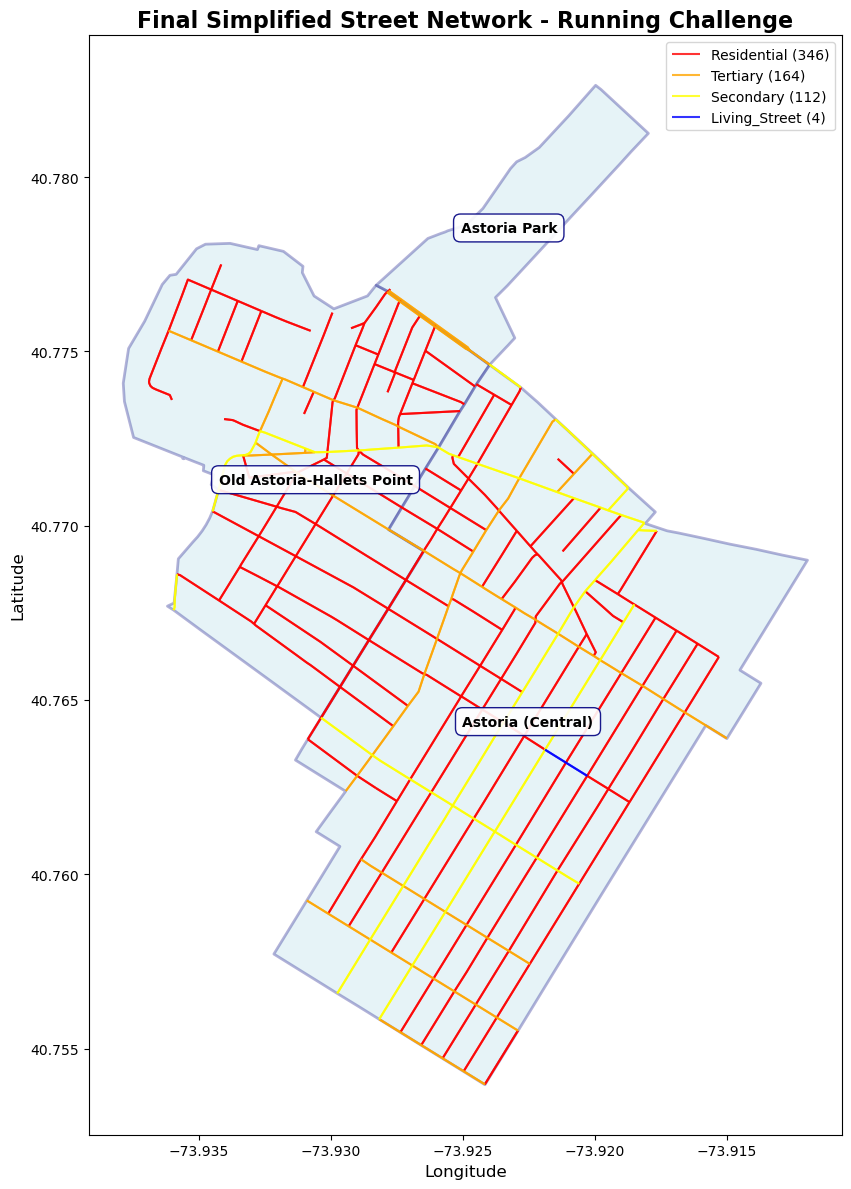


📊 G_final_streets Network Analysis:
   • residential    :  346 segments,   33.4 miles
   • tertiary       :  164 segments,    9.0 miles
   • secondary      :  112 segments,    8.3 miles
   • living_street  :    4 segments,    0.2 miles

   • TOTAL NETWORK:  626 segments,   50.9 miles
   • Reduction from original: 91.3% fewer segments


In [61]:
import geopandas as gpd
import networkx as nx
import osmnx as ox
import matplotlib.pyplot as plt

# --- ENHANCED Visualization for G_final_streets ---

print("🎨 Creating detailed visualization of G_final_streets...")

# Create visualization with proper breakdown by street type
fig, ax = plt.subplots(figsize=(15, 12))

# Plot neighborhood boundaries first
gdf_astoria.plot(ax=ax, facecolor='lightblue', edgecolor='navy', alpha=0.3, linewidth=2)

# Convert G_final_streets to GeoDataFrame
nodes_final, edges_final = ox.graph_to_gdfs(G_final_streets)

print(f"📊 G_final_streets contains {len(edges_final)} edges")

# Define colors for each street type
running_types_colors = {
    'residential': 'red',
    'tertiary': 'orange', 
    'secondary': 'yellow',
    'unclassified': 'green',
    'living_street': 'blue'
}

# Plot streets by type with different colors
for highway_type, color in running_types_colors.items():
    # Filter edges for this highway type
    type_edges = edges_final[edges_final['highway'].astype(str).str.contains(highway_type, na=False)]
    
    if not type_edges.empty:
        type_edges.plot(ax=ax, color=color, linewidth=1.5, alpha=0.8, label=f'{highway_type.title()} ({len(type_edges)})')
        print(f"   • {highway_type}: {len(type_edges)} segments")
    else:
        print(f"   • {highway_type}: 0 segments")

# Add home and gym markers (make sure coordinates are defined)
if 'home_coords' in globals():
    ax.scatter(home_coords[1], home_coords[0], c='green', s=300, marker='h', 
               label='Home', zorder=10, edgecolors='darkgreen', linewidth=3)
if 'gym_coords' in globals():
    ax.scatter(gym_coords[1], gym_coords[0], c='orange', s=300, marker='s', 
               label='Gym', zorder=10, edgecolors='darkorange', linewidth=3)

# Add neighborhood labels
for _, row in gdf_astoria.iterrows():
    p = row.geometry.representative_point()
    ax.annotate(
        row["NTAName"],
        xy=(p.x, p.y),
        ha="center", va="center",
        fontsize=10, fontweight='bold',
        bbox=dict(boxstyle="round,pad=0.5", facecolor="white", 
                 alpha=0.9, edgecolor="navy")
    )

# Styling
ax.set_title("Final Simplified Street Network - Running Challenge", fontsize=16, fontweight='bold')
ax.legend(loc='upper right', fontsize=10)
ax.set_xlabel("Longitude", fontsize=12)
ax.set_ylabel("Latitude", fontsize=12)
ax.tick_params(axis='both', which='major', labelsize=10)

plt.tight_layout()
plt.show()

# --- Calculate and Display Statistics ---
print(f"\n📊 G_final_streets Network Analysis:")
print("=" * 50)

# Calculate total distance by type
total_distance_by_type = {}
total_distance_all = 0

for highway_type in running_types_colors.keys():
    type_edges = edges_final[edges_final['highway'].astype(str).str.contains(highway_type, na=False)]
    if not type_edges.empty and 'length' in type_edges.columns:
        distance_miles = (type_edges['length'] * 0.000621371).sum()
        total_distance_by_type[highway_type] = distance_miles
        total_distance_all += distance_miles
        print(f"   • {highway_type:<15}: {len(type_edges):>4} segments, {distance_miles:>6.1f} miles")

print(f"\n   • TOTAL NETWORK: {len(edges_final):>4} segments, {total_distance_all:>6.1f} miles")

# Compare with original network if available
if 'G' in globals():
    original_edges = len(G.edges())
    reduction_percentage = ((original_edges - len(edges_final)) / original_edges) * 100
    print(f"   • Reduction from original: {reduction_percentage:.1f}% fewer segments")

print("=" * 50)

🔍 Adding all intersection dots to the existing network...
   • Dead ends (degree 1): 0 nodes
   • Simple path nodes (degree 2): 21 nodes
   • Intersections (degree 3+): 181 nodes
   • Major intersections (degree 4+): 181 nodes


/var/folders/l6/7c34hv4d1qxf6512mr1v27cc0000gn/T/ipykernel_16923/3655153568.py:97: UserWarning: Glyph 127968 (\N{HOUSE BUILDING}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/var/folders/l6/7c34hv4d1qxf6512mr1v27cc0000gn/T/ipykernel_16923/3655153568.py:97: UserWarning: Glyph 127947 (\N{WEIGHT LIFTER}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/opt/anaconda3/lib/python3.13/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 127968 (\N{HOUSE BUILDING}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
/opt/anaconda3/lib/python3.13/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 127947 (\N{WEIGHT LIFTER}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


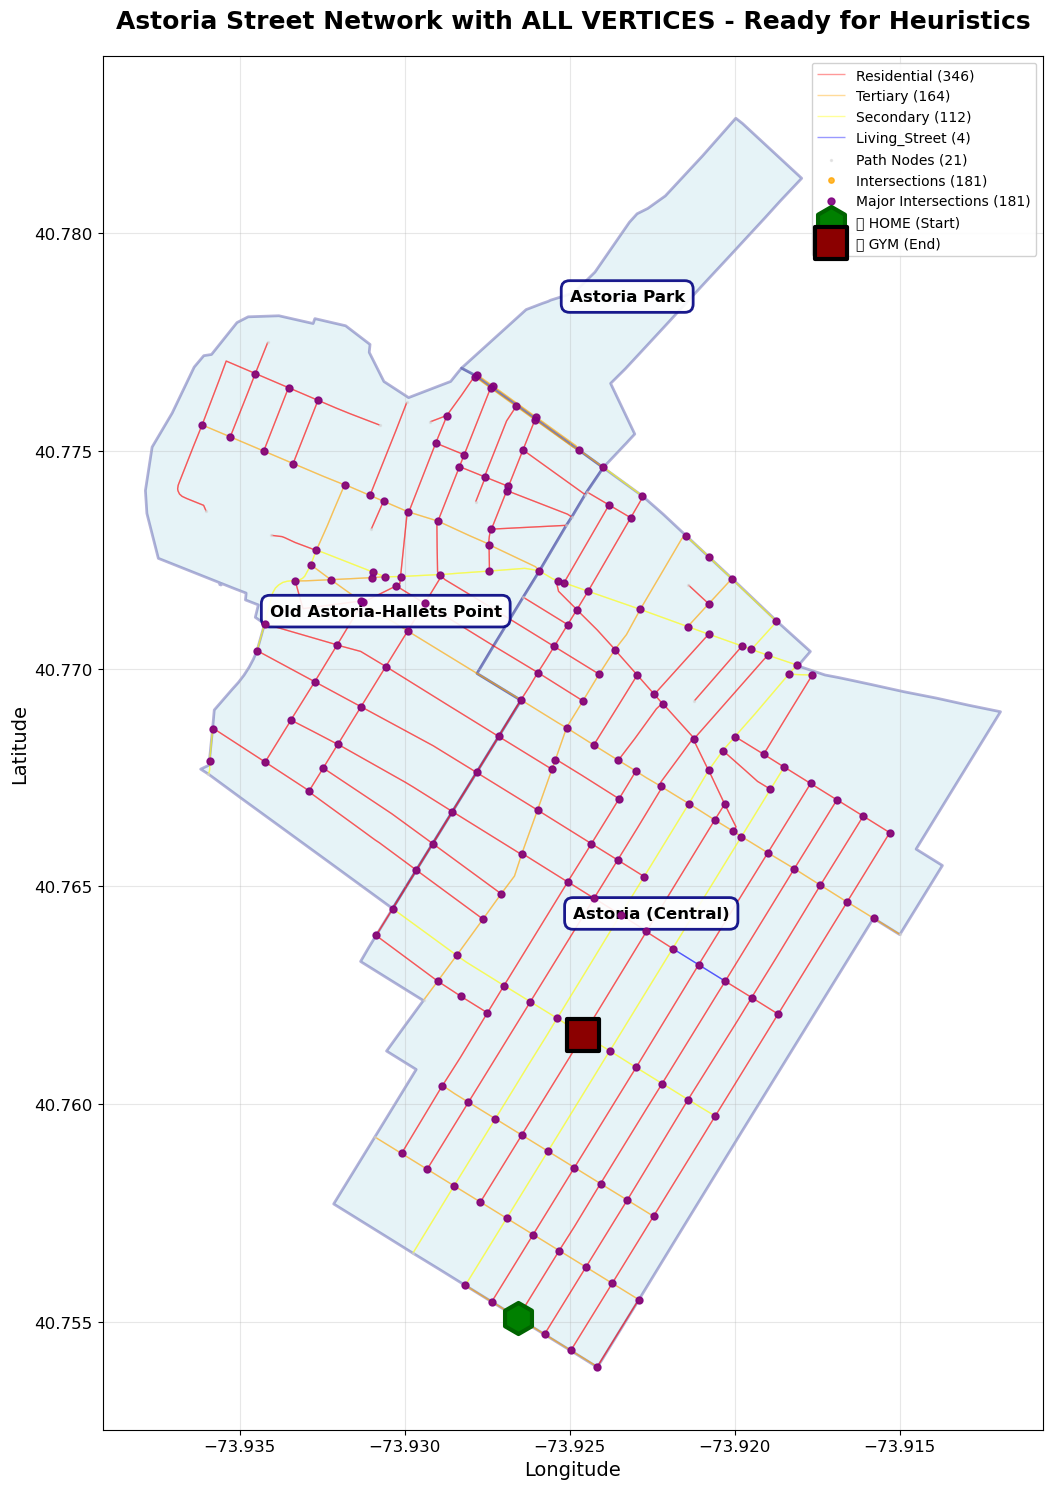


✅ Network with ALL DOTS ready for heuristic optimization!
   • Total vertices: 202 nodes
   • Graph variable: G_final_streets
   • Home node: 42866667
   • Gym node: 42882974
   • Ready to implement greedy heuristic algorithm


In [29]:
# --- ADD DOTS (VERTICES/INTERSECTIONS) TO EXISTING VISUALIZATION ---

print("🔍 Adding all intersection dots to the existing network...")

# Get node degrees to categorize intersections
degrees = dict(G_final_streets.degree())

# Categorize nodes by their degree (number of connections)
dead_ends = [node for node, degree in degrees.items() if degree == 1]
simple_paths = [node for node, degree in degrees.items() if degree == 2]
intersections = [node for node, degree in degrees.items() if degree >= 3]
major_intersections = [node for node, degree in degrees.items() if degree >= 4]

print(f"   • Dead ends (degree 1): {len(dead_ends)} nodes")
print(f"   • Simple path nodes (degree 2): {len(simple_paths)} nodes")
print(f"   • Intersections (degree 3+): {len(intersections)} nodes")
print(f"   • Major intersections (degree 4+): {len(major_intersections)} nodes")

# Create new visualization with ALL the dots
fig, ax = plt.subplots(figsize=(18, 15))

# Plot neighborhood boundaries first
gdf_astoria.plot(ax=ax, facecolor='lightblue', edgecolor='navy', alpha=0.3, linewidth=2)

# Plot streets by type with lighter colors (as background)
for highway_type, color in running_types_colors.items():
    type_edges = edges_final[edges_final['highway'].astype(str).str.contains(highway_type, na=False)]
    
    if not type_edges.empty:
        type_edges.plot(ax=ax, color=color, linewidth=1, alpha=0.4, label=f'{highway_type.title()} ({len(type_edges)})')

# --- ADD ALL THE DOTS ---
# Simple path nodes (small light gray dots)
if simple_paths:
    simple_coords = [(G_final_streets.nodes[node]['y'], G_final_streets.nodes[node]['x']) for node in simple_paths]
    simple_lats, simple_lons = zip(*simple_coords)
    ax.scatter(simple_lons, simple_lats, c='lightgray', s=2, alpha=0.5, 
               label=f'Path Nodes ({len(simple_paths)})', zorder=3)

# Dead ends (red dots)
if dead_ends:
    dead_coords = [(G_final_streets.nodes[node]['y'], G_final_streets.nodes[node]['x']) for node in dead_ends]
    dead_lats, dead_lons = zip(*dead_coords)
    ax.scatter(dead_lons, dead_lats, c='red', s=8, alpha=0.7, 
               label=f'Dead Ends ({len(dead_ends)})', zorder=4)

# Regular intersections (orange dots)
if intersections:
    intersection_coords = [(G_final_streets.nodes[node]['y'], G_final_streets.nodes[node]['x']) for node in intersections]
    int_lats, int_lons = zip(*intersection_coords)
    ax.scatter(int_lons, int_lats, c='orange', s=15, alpha=0.8, 
               label=f'Intersections ({len(intersections)})', zorder=5)

# Major intersections (purple dots)
if major_intersections:
    major_coords = [(G_final_streets.nodes[node]['y'], G_final_streets.nodes[node]['x']) for node in major_intersections]
    major_lats, major_lons = zip(*major_coords)
    ax.scatter(major_lons, major_lats, c='purple', s=25, alpha=0.9, 
               label=f'Major Intersections ({len(major_intersections)})', zorder=6)

# Add HOME and GYM markers
home = (40.75398104561959, -73.92721746021077)
gym = (40.762049034238565, -73.92476009837436)

home_node = ox.nearest_nodes(G_final_streets, home[1], home[0])
gym_node = ox.nearest_nodes(G_final_streets, gym[1], gym[0])

home_coords = G_final_streets.nodes[home_node]
gym_coords = G_final_streets.nodes[gym_node]

ax.scatter(home_coords['x'], home_coords['y'], c='green', s=500, marker='h', 
           label='🏠 HOME (Start)', zorder=10, edgecolors='darkgreen', linewidth=3)
ax.scatter(gym_coords['x'], gym_coords['y'], c='darkred', s=500, marker='s', 
           label='🏋️ GYM (End)', zorder=10, edgecolors='black', linewidth=3)

# Add neighborhood labels
for _, row in gdf_astoria.iterrows():
    p = row.geometry.representative_point()
    ax.annotate(
        row["NTAName"],
        xy=(p.x, p.y),
        ha="center", va="center",
        fontsize=12, fontweight='bold',
        bbox=dict(boxstyle="round,pad=0.5", facecolor="white", 
                 alpha=0.9, edgecolor="navy", linewidth=2)
    )

# Styling
ax.set_title("Astoria Street Network with ALL VERTICES - Ready for Heuristics", 
             fontsize=18, fontweight='bold', pad=20)
ax.legend(loc='upper right', fontsize=10, framealpha=0.9)
ax.set_xlabel("Longitude", fontsize=14)
ax.set_ylabel("Latitude", fontsize=14)
ax.tick_params(axis='both', which='major', labelsize=12)
ax.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

print(f"\n✅ Network with ALL DOTS ready for heuristic optimization!")
print(f"   • Total vertices: {len(nodes_final)} nodes")
print(f"   • Graph variable: G_final_streets")
print(f"   • Home node: {home_node}")
print(f"   • Gym node: {gym_node}")
print(f"   • Ready to implement greedy heuristic algorithm")